## Creating the 4 panel Berry figure!

To run this code, make sure you've downloaded the relevant berry output files from S3.

In [1]:
import confirm.outlaw.nb_util

confirm.outlaw.nb_util.setup_nb()
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import scipy.special
import confirm.mini_imprint.grid as berrylibgrid
import confirm.mini_imprint.binomial as binomial

# grid_info, sim_info, bound_info = np.load("output_berry3d_hi3.npy", allow_pickle=True)
# grid_info, sim_info, bound_info = np.load("../../output_berry3d_0_1000.npy", allow_pickle=True)

In [2]:
info_sets = []
max_gp = 16777216
for i in range(17):
    begin = i * 1000000
    end = min(max_gp, (i + 1) * 1000000)
    path = f"output_berry4d_{begin}_{end}.npy"
    batch_infos = np.load(path, allow_pickle=True)
    for j, info in enumerate(batch_infos):
        if j >= len(info_sets):
            info_sets.append([])
        for k, arr in enumerate(info):
            if k >= len(info_sets[j]):
                info_sets[j].append([])
            info_sets[j][k].append(arr)
for i, info in enumerate(info_sets):
    for j, arr in enumerate(info):
        info_sets[i][j] = np.concatenate(arr)

grid_info, sim_info, bound_info = info_sets

In [3]:
(theta, theta_tiles, tile_radii, corners, null_truth) = grid_info
(sim_sizes, typeI_sum, typeI_score) = sim_info
(total_gp, d0_gp, d0u_gp, d1w_gp, d1uw_gp, d2uw_gp) = bound_info

In [4]:
n_arms = theta_tiles.shape[1]
n_arm_samples = 35
null_hypos = [
    berrylibgrid.HyperPlane(-np.identity(n_arms)[i], -scipy.special.logit(0.1))
    for i in range(n_arms)
]
tree = scipy.spatial.KDTree(theta_tiles)


def eval_bound(eval_pts):
    dist, idx = tree.query(eval_pts, k=2**n_arms)
    tile_idx = np.full(eval_pts.shape[0], -1, dtype=int)
    eval_null = np.empty((eval_pts.shape[0], len(null_hypos)), dtype=bool)
    for d, H in enumerate(null_hypos):
        boundary_dist = eval_pts.dot(H.n) - H.c
        eval_null[:, d] = boundary_dist >= 0
    for i in range(2**n_arms):
        # We choose a tile if the hypotheses all match and the tile has not
        # been assigned yet. The result is that an evaluation point is assigned
        # to the tile it is closest to that matches all hypotheses.
        select = (null_truth[idx[:, i]] == eval_null).all(axis=1) & (tile_idx == -1)
        tile_idx[select] = idx[select, i]
    # assert(np.all((null_truth[tile_idx] == eval_null).all(axis=1)))
    reduced_tile_idx = tile_idx[tile_idx != -1]

    out_arrs = binomial.upper_bound(
        theta_tiles[reduced_tile_idx],
        tile_radii[reduced_tile_idx],
        eval_pts[tile_idx != -1, None, :],
        sim_sizes[reduced_tile_idx],
        n_arm_samples,
        typeI_sum[reduced_tile_idx],
        typeI_score[reduced_tile_idx],
    )
    full_out_arrs = []
    for a in out_arrs:
        a_full = np.full(eval_pts.shape[0], np.nan)
        a_full[tile_idx != -1] = a
        full_out_arrs.append(a_full)
    return full_out_arrs


In [5]:
theta_range = (-3.5, 1.0, 10)
typeI_range = (0, np.max(typeI_sum / sim_sizes))
typeI_range, theta_range

((0, 0.683342), (-3.5, 1.0, 10))

In [6]:
typeI_range = (0, 0.55)

In [29]:
from scipy.special import logit
scenarios = np.array([
    [0.05, 0.05, 0.1, 0.2], # Null
    # [0.2, 0.2, 0.3, 0.4], # Alternative
    # [0.2, 0.2, 0.2, 0.5], # One in the middle
    # [0.15, 0.15, 0.2, 0.3], # All in the middle
    [0.05, 0.05, 0.1, 0.4], # One Nugget
    [0.05, 0.05, 0.3, 0.4], # 2 Null, 2 Alt
])
p0 = np.array(
    [0.05, 0.05, 0.1, 0.2]
)  # rate of response below this is the null hypothesis
p1 = np.array(
    [0.2, 0.2, 0.3, 0.4]
)  # rate of response above this is the alternative hypothesis.

scenarios_t = logit(scenarios) - logit(p1)
thresh = logit(p0) - logit(p1)
delta_theta = scenarios_t - thresh
mapped_theta = delta_theta + logit(0.1)
mapped_theta

array([[-2.19722458, -2.19722458, -2.19722458, -2.19722458],
       [-2.19722458, -2.19722458, -2.19722458, -1.21639532],
       [-2.19722458, -2.19722458, -0.84729786, -1.21639532]])

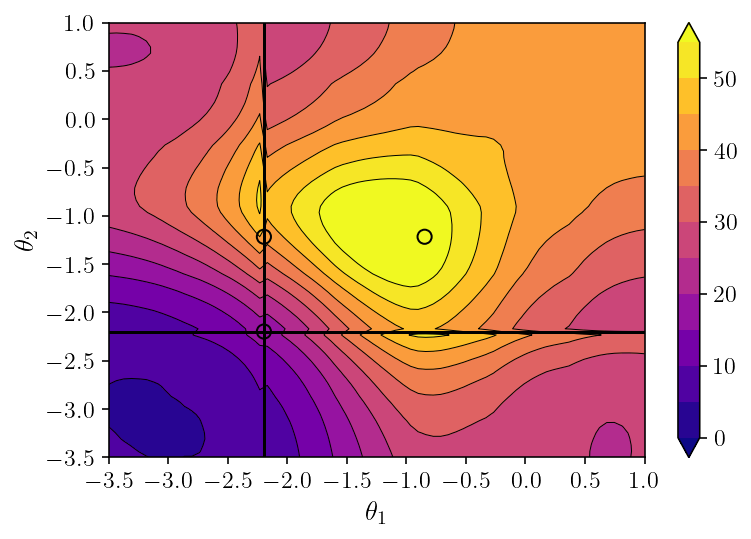

In [31]:
def set_domain(cbar_target, skipx=False, skipy=False, cbar=True, cbar_label=True):
    if cbar:
        cbar = plt.colorbar(cbar_target)
        if cbar_label:
            cbar.set_label("% Type I error upper bound")
    if skipx:
        plt.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

    else:
        plt.xlabel(r"$\theta_1$")
        plt.xticks(np.linspace(*theta_range))
    if skipy:
        plt.tick_params(
            axis="y", which="both", left=False, right=False, labelleft=False
        )
    else:
        plt.ylabel(r"$\theta_2$")
        plt.yticks(np.linspace(*theta_range))
    plt.axvline(x=scipy.special.logit(0.1), color="k", linestyle="-")
    plt.axhline(y=scipy.special.logit(0.1), color="k", linestyle="-")


def fig1(include_discussion_pts=True, include_berry_pts=False, cmap=None, n_contours=11, **kwargs):
    t0 = scipy.special.logit(0.1) - 0.001
    n1 = 72
    n2 = n1
    t1 = np.linspace(*theta_range[:2], n1)
    t2 = np.linspace(*theta_range[:2], n2)
    t12 = np.stack(np.meshgrid(t1, t2, indexing="ij"), axis=-1)
    unplotted = np.full((n1, n2, 1), t0)
    eval_pts = np.concatenate([unplotted] * (n_arms - 2) + [t12], axis=-1)
    eval_pts = eval_pts.reshape((-1, n_arms))

    bound = eval_bound(eval_pts)

    eval_pts_2d = eval_pts.reshape((n1, n2, n_arms))
    simple_slice(eval_pts_2d, bound, **kwargs)
    if include_discussion_pts: 
        plt.scatter([-2.2], [-0.9], s=50, marker='>', facecolors='none', edgecolors='k')
        plt.scatter([-1.1], [-1.1], s=50, marker='*', facecolors='none', edgecolors='k')
    if include_berry_pts:
        plt.scatter(mapped_theta[:,-2], mapped_theta[:, -1], s=50, marker='o', facecolors='none', edgecolors='k')
    return eval_pts_2d


def simple_slice(eval_pts_2d, bound, cmap=None, n_contours=12, **kwargs):
    n1, n2 = eval_pts_2d.shape[:2]

    x = eval_pts_2d[:, :, n_arms - 2]
    y = eval_pts_2d[:, :, n_arms - 1]
    z = bound[0].reshape((n1, n2))
    levels = np.linspace(*typeI_range, n_contours) * 100

    cbar_target = plt.contourf(x, y, z * 100, levels=levels, extend="both", cmap=cmap)
    plt.contour(
        x,
        y,
        z * 100,
        levels=levels,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        extend="both",
    )
    set_domain(cbar_target, **kwargs)
    return cbar_target

ev = fig1(include_discussion_pts=False, include_berry_pts=True)
plt.show()

In [41]:
S = np.log(0.1 / (1 - 0.1))
p1 = np.log(0.1 / (1 - 0.1))
S - p1

0.0

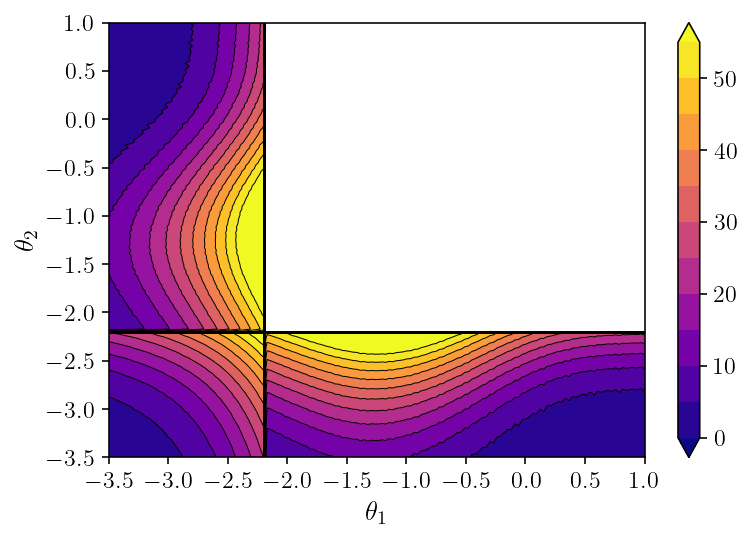

In [8]:
max_theta = theta_tiles[np.argmax(total_gp), :]


def fig2(cmap=None, n_contours=11, **kwargs):
    t0 = max_theta[0]
    n1 = 150
    n2 = n1
    t1 = np.linspace(*theta_range[:2], n1)
    t2 = np.linspace(*theta_range[:2], n2)
    t12 = np.stack(np.meshgrid(t1, t2, indexing="ij"), axis=-1)
    unplotted = np.full((n1, n2, 1), t0)
    eval_pts = np.concatenate([unplotted] * (n_arms - 2) + [t12], axis=-1)
    eval_pts = eval_pts.reshape((-1, n_arms))

    bound = eval_bound(eval_pts)

    eval_pts_2d = eval_pts.reshape((n1, n2, n_arms))
    simple_slice(eval_pts_2d, bound, **kwargs)


fig2()
plt.show()

In [9]:
def get_worst(tile_centers, pts, axes, tol):
    tree12 = scipy.spatial.cKDTree(tile_centers[:, axes])
    nearby = tree12.query_ball_point(pts, tol)
    worst_theta = np.empty((len(nearby), n_arms))
    worst_bound = np.empty(len(nearby))
    for i in range(len(nearby)):
        select = np.array(nearby[i])
        if select.shape[0] == 0:
            print(i)
        worst_idx = np.argmax(total_gp[select])
        worst_theta[i] = theta_tiles[select[worst_idx]]
        worst_bound[i] = total_gp[select[worst_idx]]
    return worst_bound, worst_theta

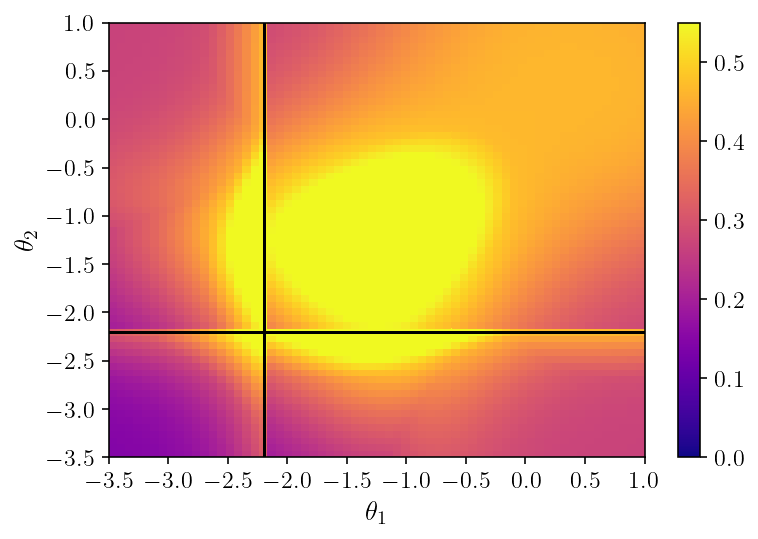

In [10]:
t2_unique = np.unique(theta_tiles[:, 2])
fig3_t12_grid = np.stack(np.meshgrid(t2_unique, t2_unique, indexing="ij"), axis=-1)
fig3_t12_pts = fig3_t12_grid.reshape((-1, 2))
fig3_worst_bound, fig3_worst_theta = get_worst(theta_tiles, fig3_t12_pts, (1, 2), 1e-10)

def fig3(**kwargs):
    cbar_target = plt.pcolor(
        fig3_t12_grid[..., 0],
        fig3_t12_grid[..., 1],
        fig3_worst_bound.reshape(fig3_t12_grid.shape[:2]),
        vmin=typeI_range[0],
        vmax=typeI_range[1],
    )
    set_domain(cbar_target, **kwargs)


fig3()
plt.show()
# cbar_target = plt.tripcolor(t1t2_pts[...,0].ravel(), t1t2_pts[...,1].ravel(), worst_bound.ravel())

In [11]:
u1s = theta_tiles.sum(axis=-1) / n_arms
u2s_idx = np.argmax(theta_tiles - scipy.special.logit(0.1), axis=-1)
u2s = theta_tiles[np.arange(theta_tiles.shape[0]), u2s_idx] - scipy.special.logit(0.1)

u1_ordering = np.argsort(u1s)
u1dist = np.append(True, np.diff(u1s[u1_ordering]))
u1_unique = u1s[u1_ordering[u1dist > 1e-10]]

u2_ordering = np.argsort(u2s)
u2dist = np.append(True, np.diff(u2s[u2_ordering]))
u2_unique = u2s[u2_ordering[u2dist > 1e-10]]

u1u2_grid = np.stack(np.meshgrid(u1_unique, u2_unique, indexing="ij"), axis=-1)
u1u2_pts = u1u2_grid.reshape((-1, 2))

u_tile_centers = np.stack((u1s, u2s), axis=-1)

In [12]:
u1u2_pts = []
u1_tree = scipy.spatial.cKDTree(u1s.reshape((-1, 1)))
u1_select = u1_tree.query_ball_point(u1_unique.reshape((-1, 1)), 1e-10)
for i in range(len(u1_select)):
    for u2v in np.unique(u2s[u1_select[i]]):
        u1u2_pts.append((u1_unique[i], u2v))
u1u2_pts = np.array(u1u2_pts)

In [13]:
u_worst_bound, u_worst_theta = get_worst(u_tile_centers, u1u2_pts, (0,1), 1e-10)

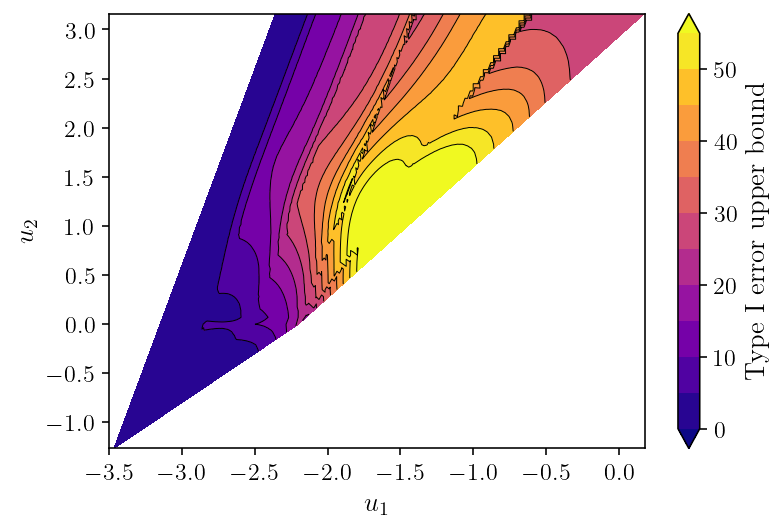

In [14]:
def fig4(cbar=True, skipx=False, skipy=False):
    x = u1u2_pts[..., 0]
    y = u1u2_pts[..., 1]
    z = u_worst_bound
    levels = np.linspace(*typeI_range, 12) * 100
    # cbar_target = plt.tripcolor(x, y, z * 100)
    cbar_target = plt.tricontourf(x, y, z * 100, levels=levels, extend="both")
    plt.tricontour(
        x,
        y,
        z * 100,
        levels=levels,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        extend="both",
    )
    if cbar:
        cbar = plt.colorbar(cbar_target)
        cbar.set_label("Type I error upper bound")

    if skipx:
        plt.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=False
        )

    else:
        plt.xlabel(r"$u_1$")
        plt.xticks(np.linspace(-3.5, 0.0, 8))
    if skipy:
        plt.tick_params(
            axis="y", which="both", left=False, right=False, labelleft=False
        )
    else:
        plt.ylabel(r"$u_2$")
        plt.yticks(np.linspace(-1, 3, 9))
    return cbar_target


fig4()
plt.show()


\begin{align}
u_1 &= (\theta_1 + \theta_2 + \theta_3 + \theta_4)/4.0\\
u_2 &= max(\theta_i - logit(p_1))
\end{align}


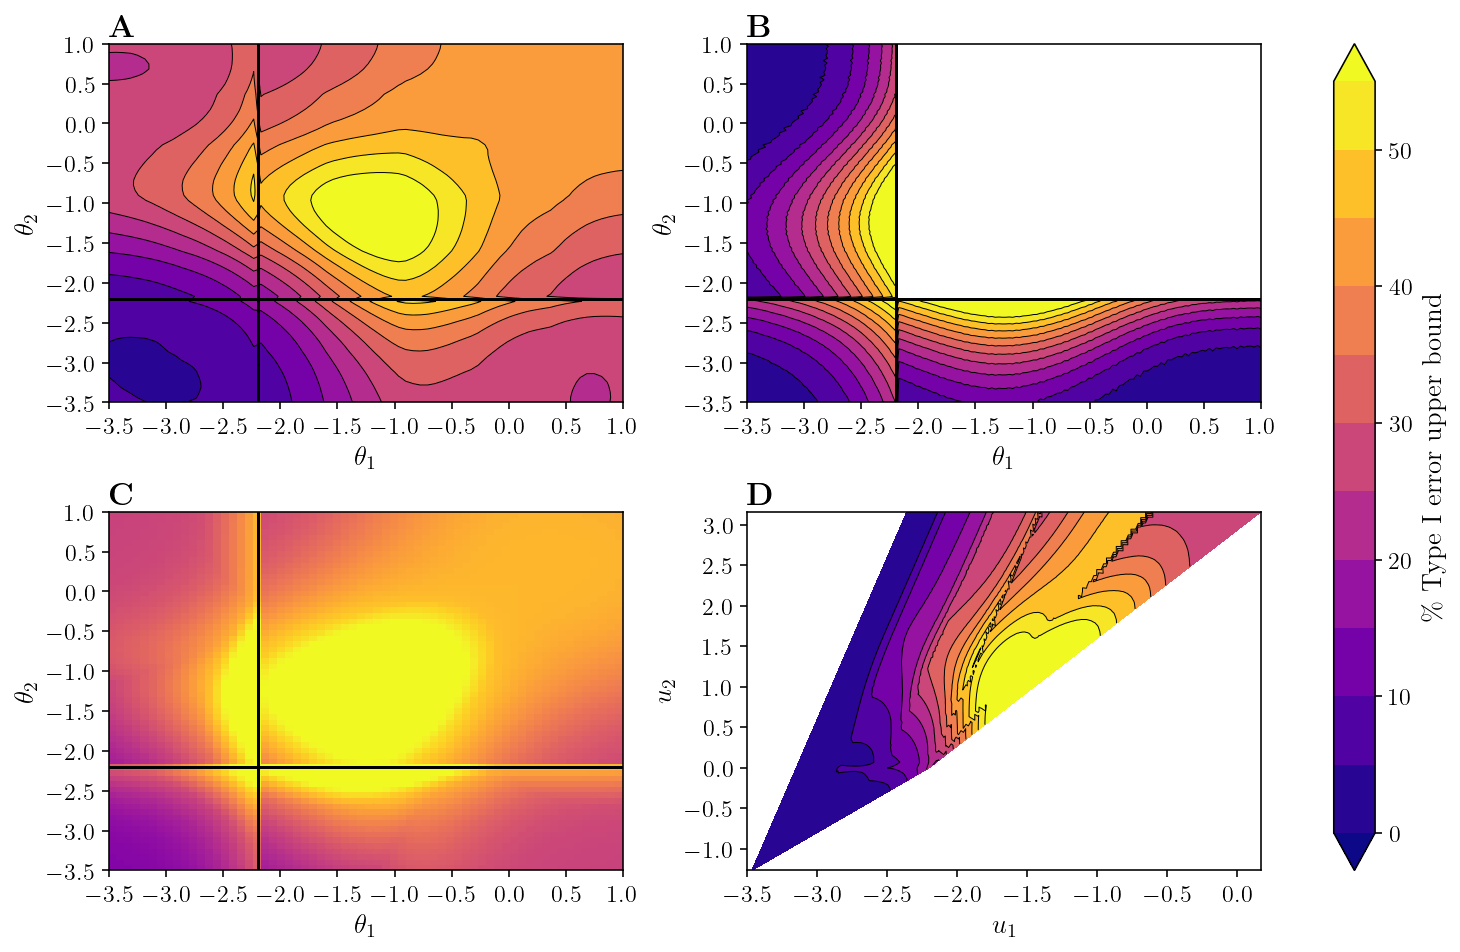

In [16]:
ratio = 8.5 / 5.5
h = 6.5
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(ratio * h, h), constrained_layout=True
)

plt.subplot(2, 2, 1)
cbar_target = fig1(cbar=False)
plt.text(-3.5, 1.1, "$\mathbf{A}$", fontsize=16)

plt.subplot(2, 2, 2)
fig2(cbar=False)
plt.text(-3.5, 1.1, "$\mathbf{B}$", fontsize=16)

plt.subplot(2, 2, 3)
fig3(cbar=False)
plt.text(-3.5, 1.1, "$\mathbf{C}$", fontsize=16)

plt.subplot(2, 2, 4)
cbar_target = fig4(cbar=False)
plt.text(-3.5, 3.25, "$\mathbf{D}$", fontsize=16)

cbar = fig.colorbar(cbar_target, ax=axes.ravel().tolist(), label="\% Type I error upper bound")

plt.savefig("berry_fig.pdf", bbox_inches='tight')
plt.show()